## 1. Загрузка и очистка данных + фиксируем seed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from risk_metrics import calc_var, backtest_var_correlated
from data_loader import set_seed, load_full_data
from models import simulate_cir, ols_cir, simulate_gbm, estimate_gbm_params, DT, get_table_trajectories, simulate_portfolio_correlated

In [2]:
rng = set_seed(42)
df = load_full_data("full_data.csv",
                    numeric_cols=["moex", "rts", "Евро", "Доллар США"])


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 2023-06-21 to 2023-12-29
Freq: B
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    138 non-null    int64  
 1   severstal     138 non-null    float64
 2   aeroflot      138 non-null    float64
 3   gazprom       138 non-null    float64
 4   lukoil        138 non-null    float64
 5   novatek       138 non-null    float64
 6   ozon          138 non-null    float64
 7   rosneft       138 non-null    float64
 8   sber          138 non-null    float64
 9   tatneft       138 non-null    float64
 10  yandex        138 non-null    float64
 11  SU26207RMFS9  138 non-null    float64
 12  SU26227RMFS7  138 non-null    float64
 13  SU26238RMFS4  138 non-null    float64
 14  SU26243RMFS4  138 non-null    float64
 15  SU25085RMFS0  138 non-null    float64
 16  brent         138 non-null    float64
 17  moex          138 non-null    float64
 18  rts

## 2. Проверка моделей: оценка параметров CIR & GBM

In [4]:
# фиксируем сид
rng = np.random.default_rng(42)

# пример: ставка (CIR) 
rates = df['SU26207RMFS9'].values          # исходная история ставок
k, theta, sig = ols_cir(rates, dt=DT)      # оценка
path_rates = simulate_cir(k, theta, sig,
                          r0=rates[-1],
                          n=10, dt=DT, rng=rng)

# пример: акция (GBM)
prices = df['gazprom'].values
mu, sigma = estimate_gbm_params(prices, dt=DT)
path_price = simulate_gbm(mu, sigma,
                          s0=prices[-1],
                          n=10, dt=DT, rng=rng)


## 3. Независимая Монте‑Карло‑симуляция (get_table_trajectories)

In [5]:
cir_assets = ['SU26207RMFS9', 'SU26227RMFS7', 'SU26238RMFS4',
              'SU26243RMFS4']

rng = np.random.default_rng(42)

simulations = get_table_trajectories(
    df[cir_assets + ['gazprom', 'moex', 'Евро']],
    cir_assets=cir_assets,
    num_trajectories=100,
    num_steps=10,
    rng=rng
)
print('Сгенерировано', len(simulations), 'траекторий.')

## 4. VaR 99 % без корреляции (calc_var) + визуализация

In [6]:
cir_assets = ['SU26207RMFS9', 'SU26227RMFS7']
base_volumes = {
    'gazprom': 1_000_000,
    'moex': 1_000_000,
    'Евро': 100_000_000,
    'SU26207RMFS9': 10_000_000,
    'SU26227RMFS7': 10_000_000
}

# фиксируем random seed
rng = np.random.default_rng(42)

# вызов calc_var
real, var_line, sims = calc_var(
    df=df,                           # исторические данные
    cir_assets=cir_assets,
    base_volumes=base_volumes,
    num_steps=10,
    num_trajectories=100,
    alpha=0.01,
    rng=rng
)


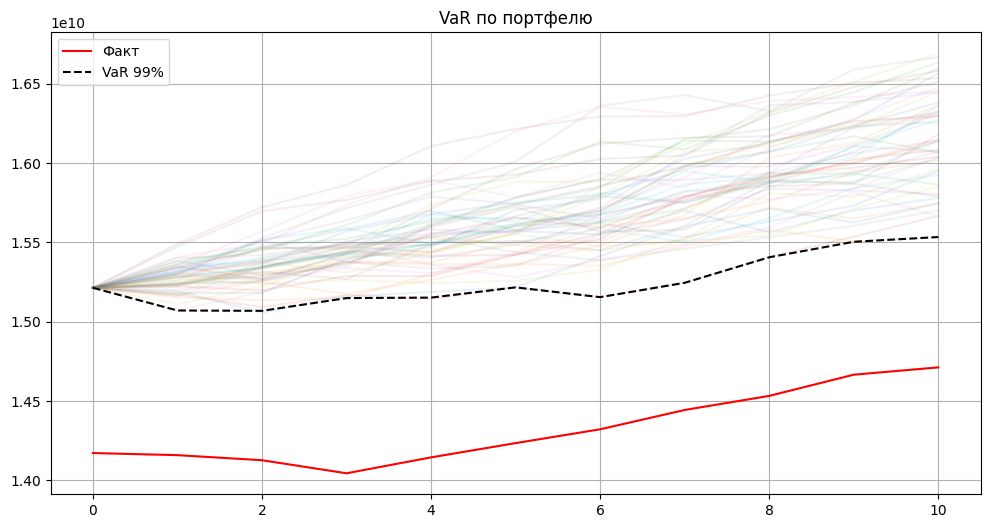

In [7]:
plt.figure(figsize=(12, 6))
for traj in sims[:50]:
    plt.plot(traj, alpha=0.1)
plt.plot(real, label="Факт", color='red')
plt.plot(var_line, label="VaR 99%", linestyle="--", color='black')
plt.legend()
plt.title("VaR по портфелю")
plt.grid(True)
plt.show()


## 5. Коррелированная симуляция портфеля (simulate_portfolio_correlated) + VaR 99 %

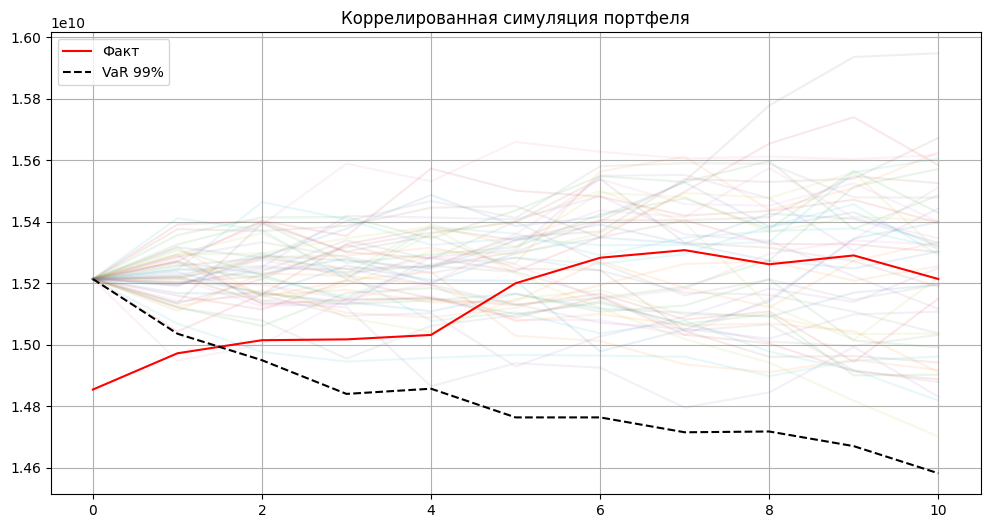

In [8]:
rng = np.random.default_rng(42)
portf_trajs = simulate_portfolio_correlated(
    df=df,
    base_volumes=base_volumes,
    num_steps=10,
    num_paths=300,
    rng=rng
)

# Реальные значения портфеля:
real_portf = sum(df[a] * base_volumes[a] for a in base_volumes).values[-11:]

# Линия VaR:
VaR_line = np.quantile(portf_trajs, 0.01, axis=0)

# Визуализация:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for path in portf_trajs[:50]:
    plt.plot(path, alpha=0.1)
plt.plot(real_portf, label='Факт', color='red')
plt.plot(VaR_line, label='VaR 99%', linestyle='--', color='black')
plt.title("Коррелированная симуляция портфеля")
plt.legend()
plt.grid()
plt.show()


## 6. Backtesting 10‑дневного VaR (коррелированная модель)

In [21]:
breaks_corr = backtest_var_correlated(
    df=df,
    base_volumes=base_volumes,
    window_size=50,         # для быстрого теста
    horizon_days=10,
    alpha=0.01,
    n_sim=200
)

print(f"Пробои (коррелированный VaR): {sum(breaks_corr)} из {len(breaks_corr)} дней")


Пробои (коррелированный VaR): 1 из 78 дней


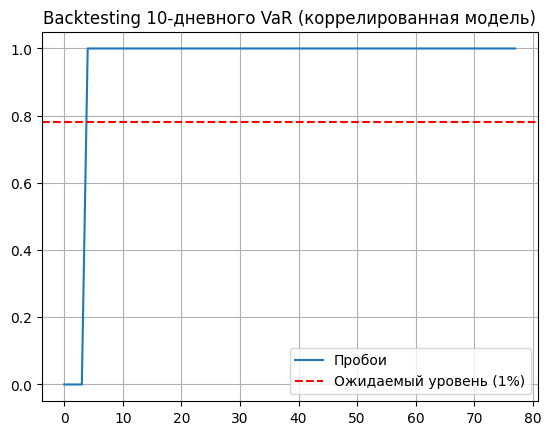

In [22]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(breaks_corr), label='Пробои')
plt.axhline(y=len(breaks_corr) * 0.01, color='red', linestyle='--', label='Ожидаемый уровень (1%)')
plt.title("Backtesting 10-дневного VaR (коррелированная модель)")
plt.legend()
plt.grid()
plt.show()
